<a href="https://colab.research.google.com/github/id-f/brain_mri_segmentation/blob/main/TRPV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに実行するセル

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')
!ls

f = "/content/drive/My Drive/Colab Notebooks/TRPV2Heart/TRPV2.xlsx"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
6匹中4匹欠損.xlsx  IDdf.xlsx  すべてのデータ.png  TRPV2.xlsx
6匹中5匹欠損.xlsx  img.png    TRPV2.ipynb


# 解析パターン１

## まずは読み込みと基本操作

In [ ]:
import pandas as pd
import numpy as np
def basedf():
  df = pd.read_excel(f)
  df = df.T
  df.columns = df.loc['Accession',:]
  df = df.drop(index= 'Accession')
  #Normalizeのみ選択。
  l = ['Abundances (Normalized): F1: Sample, WT, WT1',
    'Abundances (Normalized): F2: Sample, WT, WT2',
    'Abundances (Normalized): F3: Sample, WT, WT3',
    'Abundances (Normalized): F4: Sample, KO, KO1',
    'Abundances (Normalized): F5: Sample, KO, KO2',
    'Abundances (Normalized): F6: Sample, KO, KO3']
  #NormalizeのみのDfを作成し、クラスを追加
  df = df.loc[l, :].copy()
  df.loc[:,"class"] = [0,0,0,1,1,1]
  #Classを先頭列に
  yo = df.loc[:,"class"]  
  df.drop("class", axis=1, inplace = True)
  df.insert(0,"class",yo)

  #ネズミ名をわかりやすくする。列名変更
  nl = ["F1","F2","F3","F4","F5","F6"]
  df.index = nl
     
  return df

In [ ]:
df = basedf()

Accession,B2RWG1,Q3UV17,O08692,Q9Z284
F1,8.3871e+06,14274.6,4.75204e+06,2.04913e+06
F2,8.26407e+06,NaN,6.55603e+06,NaN
F3,1.28314e+07,3.39843e+07,3.19329e+06,NaN
F4,NaN,3.80761e+07,NaN,NaN
F5,NaN,1.40061e+06,NaN,NaN
F6,NaN,5.62708e+07,NaN,NaN


## UniprotIDがあってもGene Name が欠損しているタンパクをリスト化

In [ ]:
def uniprot_genename():
    df = pd.read_excel(f)
    df = df.T
    IDdf = df.loc[['Accession','Description', 'Symbol'],:].T
    IDdf.to_excel("IDdf.xlsx")
    return IDdf
IDdf = uniprot_genename()

In [ ]:
IDdf = IDdf.loc[:,["Accession","Symbol"]]
IDdf.loc[:, "Symbol"] = IDdf.loc[:, "Symbol"].str.strip()
IDdf[IDdf.iloc[:, 1] == ""].shape

(53, 2)

## テキスト６匹中、４匹、５匹分欠損しているデータを出力

In [ ]:
os.chdir('/content/')
dfout=df.loc[:,df.isnull().sum() >= 5]
dfout.to_excel("6匹中5匹欠損.xlsx")
dfout=df.loc[:,df.isnull().sum() == 4]
dfout.to_excel("6匹中4匹欠損.xlsx")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')

## データフレームのすべての値を並べて、出現頻度のHistgramを出力

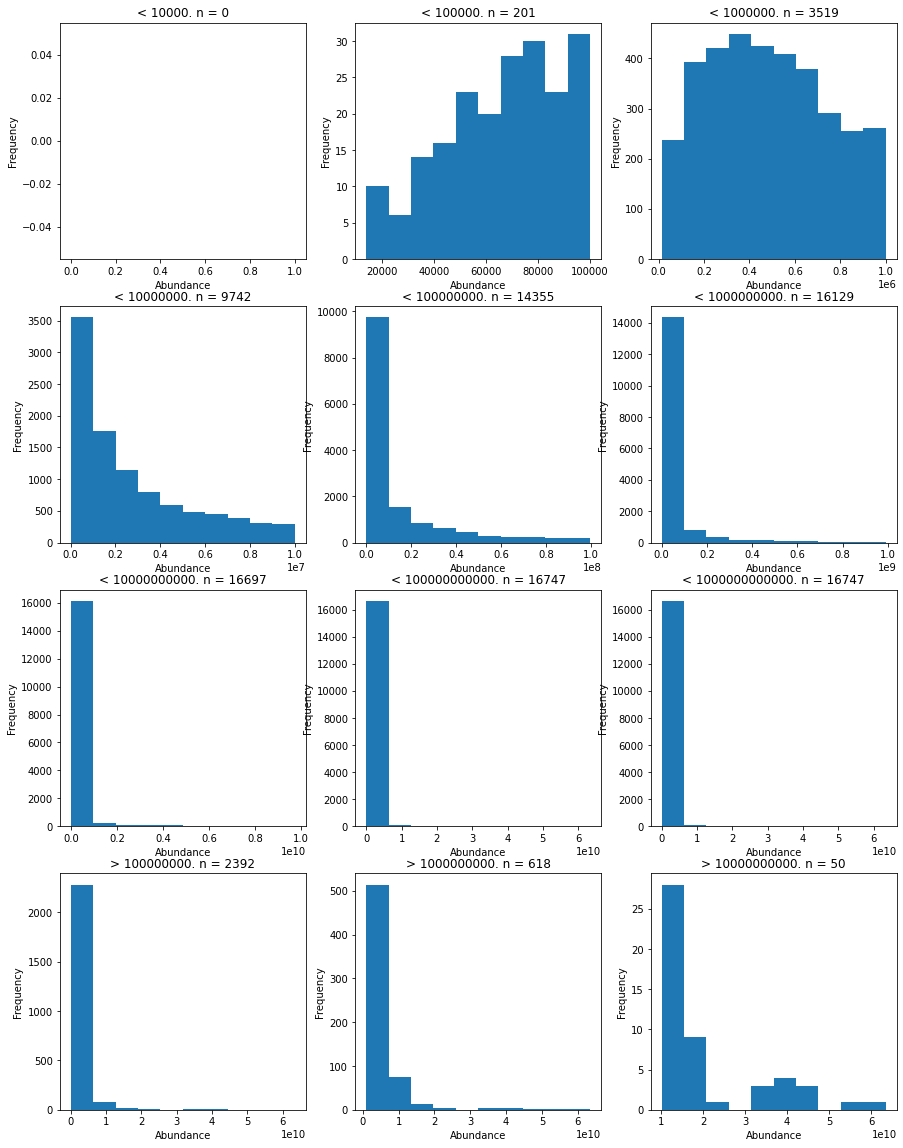

In [ ]:
#データフレームのすべての値を並べて、出現頻度のHistgramを出力
arr = df.drop(["class"],axis=1).to_numpy()
arr = arr.flatten()
arr = arr.astype(float)
arr = arr[~np.isnan(arr)]

arrlist = []
ran = [10**x for x in range(4,13)]
for i in ran:arrlist.append(arr[arr<i])

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(nrows=4, ncols=3, figsize=(15,20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for ax, arr, r in zip(ax, arrlist, ran):
  ax.hist(arr)
  ax.set_title("< {}. n = {}".format(r, arr.shape[0]))
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Abundance")

ax = [ax10, ax11, ax12]
arrlist = []
ran = [10**x for x in range(8,11)]
for i in ran:arrlist.append(arr[arr>i])
for ax, arr, r in zip(ax, arrlist, ran):
  ax.hist(arr)
  ax.set_title("> {}. n = {}".format(r, arr.shape[0]))
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Abundance")

os.chdir('/content/')
fig.savefig("hist.jpg")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')


## 四分位点チェック

In [ ]:
arr = df.drop(["class"],axis=1).to_numpy()
arr = arr.flatten()
arr = arr.astype(float)
arr = arr[~np.isnan(arr)]

np.percentile(arr,[0,25,50,75,100])
#upper = np.percentile(arr,[0,25,50,75,100])[1]


array([1.39433260e+04, 1.31400069e+06, 6.15831673e+06, 3.66382528e+07,
       6.33943995e+10])

## 欠損削除の条件

In [ ]:
def exclude(df, atleast):
  exclude1 = df.loc[:,df.isnull().sum() >= atleast].columns.values
  dfex = df.loc[:,exclude1].copy()
  print("欠損数 {} 個以上タンパク質は除外。除外タンパク質数は {}。".format(atleast, len(exclude1)))
  for i in range(atleast,6):print("欠損が {} 匹で見られたタンパク質の数は {} です。".format(i,dfex.loc[:, dfex.isnull().sum()==i].shape[1]))
  df = df.drop(exclude1, axis=1)
  return df

atleast = 5
df = exclude(df, atleast)

欠損数 5 個以上タンパク質は除外。除外タンパク質数は 11。
欠損が 5 匹で見られたタンパク質の数は 11 です。


## Imputation  Imputa = 最低値としている

In [ ]:
def imputation_med():
  #各クラスのmedianデータで欠損値を保管
  df = basedf()
  yo = df.loc[:,"class"]  
  df = df.groupby(["class"], as_index=False).transform(lambda x: x.fillna(x.median()))
  df.insert(0,"class",yo)
  return df

def imputation_class_nan(df,imputa): 
  #クラス全体がnanの項目保存。
  dfnan = df.loc[:,df.isnull().sum() >0].copy()
  print("クラスまるごと欠損タンパク出力")
  os.chdir('/content/')
  dfnan.to_excel("nulls.xlsx")
  os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')
  #欠損補完
  df = df.fillna(imputa)
  return df

df = imputation_med()
imputa = np.min(arr)
df = imputation_class_nan(df,imputa)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


クラスまるごと欠損タンパク出力


## 対数化

In [ ]:
def logarithmic_transform(df):
  yo = df.loc[:, "class"]  
  df.drop("class", axis=1, inplace = True)
  df = np.log2(df)
  df.insert(0,"class",yo)
  return df

df = logarithmic_transform(df)

## Lasso

In [ ]:
def dolasso(alpha,x_train,x_test, y_train, y_test):
    lss = Lasso(alpha=alpha)
    lss.fit(x_train, y_train)
    y_pred = lss.predict(x_test)
    y_pred_r  = y_pred.round() #四捨五入。
    score = lss.score(x_test, y_test)
    return lss, y_pred,y_pred_r, score

In [ ]:
from sklearn.metrics import f1_score
skf = StratifiedKFold(n_splits=3)
y = df.loc[:,"class"]
X = df.drop(columns="class")
y = y.to_numpy()
X = X.to_numpy()
diclist = []

for alpha in [1, 0.1, 0.05, 0.01, 0.001,0.0001, 0.00001]:
  for train_index, test_index in skf.split(X,y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      lss, y_pred, y_pred_r, score = dolasso(alpha,X_train, X_test,y_train, y_test)

      n = lss.coef_
      #print("係数が０でない変数の個数は {}".format(np.sum(lss.coef_ != 0)))
      l =[]
      d = {}
      d["alpha"] = alpha
      d["y_pred"] = y_pred
      d["y_pred_r"] = y_pred_r
      d["y_test"] = y_test  
      d["score"] = score
      d["lss.coef_not0"] =  np.sum(lss.coef_ != 0)
      #βが０で無いタンパクを列として追加する。
      Xcols = df.drop(columns="class").columns.values
      for i, e in enumerate(lss.coef_):
        if e != 0:
          d[Xcols[i]] = e
      diclist.append(d)    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e-04, tolerance: 1.000e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e-04, tolerance: 1.000e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [ ]:
diclist  #Q9Y5S1
dfo = pd.DataFrame(diclist)
os.chdir('/content/')
dfo.to_excel("lassoResult.xlsx")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

skf = StratifiedKFold(n_splits=2)
y = df.loc[:,"class"]
X = df.drop(columns="class")
y = y.to_numpy()
X = X.to_numpy()
diclist = []

for alpha in [1, 0.1, 0.05, 0.01, 0.001]:
  for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lss, y_pred,y_pred_r, score = dolasso(alpha,X_train, X_test,y_train, y_test) 
    n = lss.coef_
    #print("係数が０でない変数の個数は {}".format(np.sum(lss.coef_ != 0)))
    l =[]
    d = {}
    d["alpha"] = alpha
    d["y_pred"] = y_pred
    d["y_pred_r"] = y_pred_r
    d["score"] = score
    d["y_test"] = y_test  
    d["lss.coef_not0"] =  np.sum(lss.coef_ != 0)
    #βが０で無いタンパクを列として追加する。
    Xcols = df.drop(columns="class").columns.values
    for i, e in enumerate(lss.coef_):
      if e != 0:
        d[Xcols[i]] = e
    diclist.append(d)    
    

In [ ]:
dfo = pd.DataFrame(diclist)
dfo 

,alpha,y_pred,y_pred_r,score,y_test,lss.coef_not0,B2RWG1
0,1.000,"[0.6666666666666666, 0.6666666666666666, 0.666...","[1.0, 1.0, 1.0]",-0.500000,"[0, 0, 1]",0,NaN
1,1.000,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.0, 0.0, 0.0]",-0.500000,"[0, 1, 1]",0,NaN
2,0.100,"[0.4060134166776903, 0.406738555259905, 0.8072...","[0.0, 0.0, 1.0]",0.448866,"[0, 0, 1]",1,-0.541984
3,0.100,"[0.18232352465702562, 0.5944318986739314, 0.59...","[0.0, 1.0, 1.0]",0.456681,"[0, 1, 1]",1,-0.529465
4,0.050,"[0.22740117923844672, 0.2286232179154366, 0.90...","[0.0, 0.0, 1.0]",0.830103,"[0, 0, 1]",1,-0.913378
5,0.050,"[0.0650411598729077, 0.7972151314540286, 0.797...","[0.0, 1.0, 1.0]",0.870289,"[0, 1, 1]",1,-0.940677
6,0.010,"[0.08451138928705237, 0.08613094803986243, 0.9...","[0.0, 0.0, 1.0]",0.977602,"[0, 0, 1]",1,-1.210493
7,0.010,"[-0.02878473195438591, 0.9594417176781063, 0.9...","[-0.0, 1.0, 1.0]",0.993822,"[0, 1, 1]",1,-1.269646
8,0.001,"[0.052361186547988936, 0.0540701873178584, 0.9...","[0.0, 0.0, 1.0]",0.991497,"[0, 0, 1]",1,-1.277344
9,0.001,"[-0.04989555761552644, 0.9959426995785208, 0.9...","[-0.0, 1.0, 1.0]",0.996216,"[0, 1, 1]",1,-1.343664


## LASSOで２つだけでモデル決まる。おかしい。以下見みるとNANが多いタンパク。

In [ ]:
df.loc[:, ["B2RWG1","Q3UV17","O08692","Q9Z284"]]

Accession,B2RWG1,Q3UV17,O08692,Q9Z284
F1,8.3871e+06,14274.6,4.75204e+06,2.04913e+06
F2,8.26407e+06,NaN,6.55603e+06,NaN
F3,1.28314e+07,3.39843e+07,3.19329e+06,NaN
F4,NaN,3.80761e+07,NaN,NaN
F5,NaN,1.40061e+06,NaN,NaN
F6,NaN,5.62708e+07,NaN,NaN


In [ ]:
os.chdir('/content/')
df.loc[:, ["B2RWG1","Q3UV17","O08692","Q9Z284"]].to_excel("4vals.xlsx")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')

# 解析パターン２ （実行前にランタイム再起動を）　Impuputationパターンなど変更

## Df作成

In [ ]:
import pandas as pd
import numpy as np
def basedf(atleast,imputa):
  df = pd.read_excel(f)
  df = df.T
  df.columns = df.loc['Accession',:]
  df = df.drop(index= 'Accession')
  #Normalizeのみ選択。
  l = ['Abundances (Normalized): F1: Sample, WT, WT1',
    'Abundances (Normalized): F2: Sample, WT, WT2',
    'Abundances (Normalized): F3: Sample, WT, WT3',
    'Abundances (Normalized): F4: Sample, KO, KO1',
    'Abundances (Normalized): F5: Sample, KO, KO2',
    'Abundances (Normalized): F6: Sample, KO, KO3']
  #NormalizeのみのDfを作成し、クラスを追加
  df = df.loc[l, :].copy()
  df.loc[:,"class"] = [0,0,0,1,1,1]
  #Classを先頭列に
  yo = df.loc[:,"class"]  
  df.drop("class", axis=1, inplace = True)
  df.insert(0,"class",yo)

  #ネズミ名をわかりやすくする。列名変更
  nl = ["F1","F2","F3","F4","F5","F6"]
  df.index = nl    

  #除外
  exclude1 = df.loc[:,df.isnull().sum() >= atleast].columns.values
  dfex = df.loc[:,exclude1].copy()
  print("欠損数 {} 個以上タンパク質は除外。除外タンパク質数は {}。".format(atleast, len(exclude1)))
  for i in range(atleast,6):print("欠損が {} 匹で見られたタンパク質の数は {} です。".format(i,dfex.loc[:, dfex.isnull().sum()==i].shape[1]))
  df = df.drop(exclude1, axis=1)

  #各クラスのmedianデータで欠損値を保管
  yo = df.loc[:,"class"]  
  df = df.groupby(["class"], as_index=False).transform(lambda x: x.fillna(x.median()))
  df.insert(0,"class",yo)

  #クラス全体がnanの項目保存。
  dfnan = df.loc[:,df.isnull().sum() >0].copy()
  print("クラスまるごと欠損タンパク出力")
  os.chdir('/content/')
  dfnan.to_excel("nulls.xlsx")
  os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')
  #欠損補完
  df = df.fillna(imputa)
  return df


## 対数化

In [ ]:
def logarithmic_transform(df):
  yo = df.loc[:, "class"]  
  df.drop("class", axis=1, inplace = True)
  df = np.log2(df)
  df.insert(0,"class",yo)
  return df


## Lasso定義

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def doCross_and_Lasso(df):
  def dolasso(alpha,x_train,x_test, y_train, y_test):
    lss = Lasso(alpha=alpha)
    lss.fit(x_train, y_train)
    y_pred = lss.predict(x_test)
    y_pred_r  = y_pred.round() #四捨五入。
    score = lss.score(x_test, y_test)
    return lss, y_pred,y_pred_r, score
  
  skf = StratifiedKFold(n_splits=3)
  y = df.loc[:,"class"]
  X = df.drop(columns="class")
  y = y.to_numpy()
  X = X.to_numpy()

  diclist = []
  for alpha in [1, 0.1, 0.05, 0.01, 0.001,0.0001]:
    for train_index, test_index in skf.split(X,y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      lss, y_pred,y_pred_r, score = dolasso(alpha,X_train, X_test,y_train, y_test) 
      n = lss.coef_
      #print("係数が０でない変数の個数は {}".format(np.sum(lss.coef_ != 0)))
      l =[]
      d = {}
      d["alpha"] = alpha
      d["y_pred"] = y_pred
      d["y_pred_r"] = y_pred_r
      d["score"] = score
      d["y_test"] = y_test  
      d["lss.coef_not0"] =  np.sum(lss.coef_ != 0)
      #βが０で無いタンパクを列として追加する。
      Xcols = df.drop(columns="class").columns.values
      for i, e in enumerate(lss.coef_):
        if e != 0:
          d[Xcols[i]] = e
      diclist.append(d)    
  return diclist

## 実行

In [ ]:
dflist = []
for k in [1.39433260e+04, 1.31400069e+06]:
  imputa = round(k)
  for i in range(4, 6):
    atleast = i   
    df = basedf(atleast,imputa)
    df = logarithmic_transform(df)
    d = doCross_and_Lasso(df)
    resdf = pd.DataFrame(d)
    resdf.loc[:, "imputation"] = imputa
    resdf.loc[:, "exclude_cutoff"] = atleast
    dflist.append(resdf) 

os.chdir('/content/')
out = pd.concat([dflist[x] for x in range(0,len(dflist))])
ya = out.loc[:, "imputation"] 
yb = out.loc[:, "exclude_cutoff"]
out.drop(["imputation","exclude_cutoff"], axis=1, inplace = True)
out.insert(0,"imputation",ya)
out.insert(0,"exclude_cutoff",yb)
out.to_excel("CrossLassoImputaionMissing考慮解析結果.xlsx")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')

# 解析パターン３　Class全体がNanのものを削除 (ランタイム再起動を）

In [ ]:
import pandas as pd
import numpy as np
def basedf(atleast,imputa):
  df = pd.read_excel(f)
  df = df.T
  df.columns = df.loc['Accession',:]
  df = df.drop(index= 'Accession')
  #Normalizeのみ選択。
  l = ['Abundances (Normalized): F1: Sample, WT, WT1',
    'Abundances (Normalized): F2: Sample, WT, WT2',
    'Abundances (Normalized): F3: Sample, WT, WT3',
    'Abundances (Normalized): F4: Sample, KO, KO1',
    'Abundances (Normalized): F5: Sample, KO, KO2',
    'Abundances (Normalized): F6: Sample, KO, KO3']
  #NormalizeのみのDfを作成し、クラスを追加
  df = df.loc[l, :].copy()
  df.loc[:,"class"] = [0,0,0,1,1,1]
  #Classを先頭列に
  yo = df.loc[:,"class"]  
  df.drop("class", axis=1, inplace = True)
  df.insert(0,"class",yo)

  #ネズミ名をわかりやすくする。列名変更
  nl = ["F1","F2","F3","F4","F5","F6"]
  df.index = nl    

  #除外
  exclude1 = df.loc[:,df.isnull().sum() >= atleast].columns.values
  dfex = df.loc[:,exclude1].copy()
  print("欠損数 {} 個以上タンパク質は除外。除外タンパク質数は {}。".format(atleast, len(exclude1)))
  for i in range(atleast,6):print("欠損が {} 匹で見られたタンパク質の数は {} です。".format(i,dfex.loc[:, dfex.isnull().sum()==i].shape[1]))
  df = df.drop(exclude1, axis=1)

  #各クラスのmedianデータで欠損値を保管
  yo = df.loc[:,"class"]  
  df = df.groupby(["class"], as_index=False).transform(lambda x: x.fillna(x.median()))
  df.insert(0,"class",yo)

  #クラス全体がnanのタンパクを削除
  dfnan = df.loc[:,df.isnull().sum() >0].copy()
  exclude = dfnan.columns.values
  df = df.drop(exclude, axis=1)
  
  #欠損補完は無し。
  return df


In [ ]:
df = basedf(atleast=5,imputa=60000)
df.isnull().sum()

欠損数 5 個以上タンパク質は除外。除外タンパク質数は 11。
欠損が 5 匹で見られたタンパク質の数は 11 です。


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [ ]:
def logarithmic_transform(df):
  yo = df.loc[:, "class"]  
  df.drop("class", axis=1, inplace = True)
  df = np.log2(df)
  df.insert(0,"class",yo)
  return df

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def doCross_and_Lasso(df):
  def dolasso(alpha,x_train,x_test, y_train, y_test):
    lss = Lasso(alpha=alpha)
    lss.fit(x_train, y_train)
    y_pred = lss.predict(x_test)
    y_pred_r  = y_pred.round() #四捨五入。
    score = lss.score(x_test, y_test)
    return lss, y_pred,y_pred_r, score
  
  skf = StratifiedKFold(n_splits=3)
  y = df.loc[:,"class"]
  X = df.drop(columns="class")
  y = y.to_numpy()
  X = X.to_numpy()

  diclist = []
  for alpha in [1, 0.1, 0.05, 0.01, 0.001,0.0001]:
    for train_index, test_index in skf.split(X,y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      lss, y_pred,y_pred_r, score = dolasso(alpha,X_train, X_test,y_train, y_test) 
      n = lss.coef_
      #print("係数が０でない変数の個数は {}".format(np.sum(lss.coef_ != 0)))
      l =[]
      d = {}
      d["alpha"] = alpha
      d["y_pred"] = y_pred
      d["y_pred_r"] = y_pred_r
      d["score"] = score
      d["y_test"] = y_test  
      d["lss.coef_not0"] =  np.sum(lss.coef_ != 0)
      #βが０で無いタンパクを列として追加する。
      Xcols = df.drop(columns="class").columns.values
      for i, e in enumerate(lss.coef_):
        if e != 0:
          d[Xcols[i]] = e
      diclist.append(d)    
  return diclist

In [ ]:
dflist = []

imputa = "not used"

for i in range(4, 6):
  atleast = i   
  df = basedf(atleast,imputa)
  df = logarithmic_transform(df)
  d = doCross_and_Lasso(df)
  resdf = pd.DataFrame(d)
  resdf.loc[:, "imputation"] = imputa
  resdf.loc[:, "exclude_cutoff"] = atleast
  dflist.append(resdf) 

os.chdir('/content/')
out = pd.concat([dflist[x] for x in range(0,len(dflist))])
ya = out.loc[:, "imputation"] 
yb = out.loc[:, "exclude_cutoff"]
out.drop(["imputation","exclude_cutoff"], axis=1, inplace = True)
out.insert(0,"imputation",ya)
out.insert(0,"exclude_cutoff",yb)
out.to_excel("CrossLassoImputaionMissing考慮解析結果.xlsx")
os.chdir('/content/drive/My Drive/Colab Notebooks/TRPV2Heart/')

欠損数 4 個以上タンパク質は除外。除外タンパク質数は 30。
欠損が 4 匹で見られたタンパク質の数は 19 です。
欠損が 5 匹で見られたタンパク質の数は 11 です。


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-04, tolerance: 1.000e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


欠損数 5 個以上タンパク質は除外。除外タンパク質数は 11。
欠損が 5 匹で見られたタンパク質の数は 11 です。


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-04, tolerance: 1.000e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
